In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, average_precision_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('creditcard.csv')

print(df.shape)
print(df['Class'].value_counts())
print(df.head())

(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.7982

In [38]:
# Separate features and labels
X = df.drop('Class', axis=1).values
y = df['Class'].values

# Scale Amount and Time (V1-V28 are already scaled from PCA)
scaler = StandardScaler()
X[:, 0] = scaler.fit_transform(X[:, 0].reshape(-1, 1)).flatten()   # Time
X[:, -1] = scaler.fit_transform(X[:, -1].reshape(-1, 1)).flatten() # Amount

# Split: train ONLY on normal transactions
X_normal = X[y == 0]
X_fraud  = X[y == 1]

# Train/val split from normal data
split = int(0.8 * len(X_normal))
X_train = X_normal[:split]
X_val   = X_normal[split:]

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
X_fraud_t = torch.tensor(X_fraud, dtype=torch.float32)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train_t), batch_size=256, shuffle=True)

print(f"Train (normal): {X_train_t.shape}")
print(f"Val   (normal): {X_val_t.shape}")
print(f"Fraud samples:  {X_fraud_t.shape}")

Train (normal): torch.Size([227452, 30])
Val   (normal): torch.Size([56863, 30])
Fraud samples:  torch.Size([492, 30])


In [39]:
class VAE(nn.Module):
    def __init__(self, input_dim=30, latent_dim=8):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu      = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h        = self.encoder(x)
        mu       = self.mu(h)
        log_var  = self.log_var(h)
        z        = self.reparameterize(mu, log_var)
        x_recon  = self.decoder(z)
        return x_recon, mu, log_var


def vae_loss(x_recon, x, mu, log_var, beta=4):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss    = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl_loss


model = VAE(input_dim=30, latent_dim=8)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=32, out_features=8, bias=True)
  (log_var): Linear(in_features=32, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)

Total parameters: 8,942


Epoch 10/200 | Loss: 24.339901
Epoch 20/200 | Loss: 23.762295
Epoch 30/200 | Loss: 23.464017
Epoch 40/200 | Loss: 23.385895
Epoch 50/200 | Loss: 23.343236
Epoch 60/200 | Loss: 23.309833
Epoch 70/200 | Loss: 23.287474
Epoch 80/200 | Loss: 23.250599
Epoch 90/200 | Loss: 23.264593
Epoch 100/200 | Loss: 23.235565
Epoch 110/200 | Loss: 23.236164
Epoch 120/200 | Loss: 23.232897
Epoch 130/200 | Loss: 23.220814
Epoch 140/200 | Loss: 23.226917
Epoch 150/200 | Loss: 23.184904
Epoch 160/200 | Loss: 23.180461
Epoch 170/200 | Loss: 23.190902
Epoch 180/200 | Loss: 23.182142
Epoch 190/200 | Loss: 23.152578
Epoch 200/200 | Loss: 23.153135


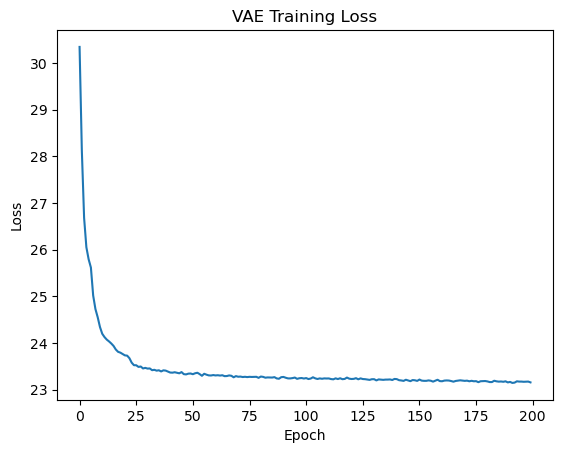

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200

train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for (batch,) in train_loader:
        optimizer.zero_grad()
        x_recon, mu, log_var = model(batch)
        loss = vae_loss(x_recon, batch, mu, log_var)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(X_train_t)
    train_losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")

# Plot training curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.show()

In [41]:
model.eval()

def get_anomaly_scores(data):
    with torch.no_grad():
        x_recon, mu, log_var = model(data)
        recon_loss = F.mse_loss(x_recon, data, reduction='none').sum(dim=1)
        kl_loss    = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)
        return (recon_loss + kl_loss).numpy()

# Score normal (val) and fraud
scores_normal = get_anomaly_scores(X_val_t)
scores_fraud  = get_anomaly_scores(X_fraud_t)

# Set threshold at 95th percentile of normal scores
threshold = np.percentile(scores_normal, 95)
print(f"Threshold: {threshold:.4f}")
print(f"Avg score - Normal: {scores_normal.mean():.4f}")
print(f"Avg score - Fraud:  {scores_fraud.mean():.4f}")

Threshold: 44.2262
Avg score - Normal: 21.6419
Avg score - Fraud:  155.7650


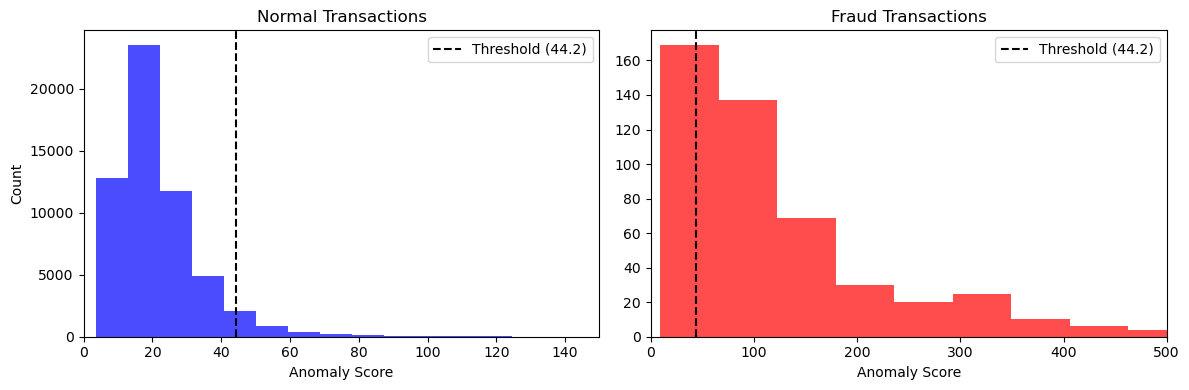

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(scores_normal, bins=100, color='blue', alpha=0.7)
ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.1f})')
ax1.set_title('Normal Transactions')
ax1.set_xlabel('Anomaly Score')
ax1.set_ylabel('Count')
ax1.set_xlim(0, 150)
ax1.legend()

ax2.hist(scores_fraud, bins=30, color='red', alpha=0.7)
ax2.axvline(threshold, color='black', linestyle='--', label=f'Threshold ({threshold:.1f})')
ax2.set_title('Fraud Transactions')
ax2.set_xlabel('Anomaly Score')
ax2.set_xlim(0, 500)
ax2.legend()

plt.tight_layout()
plt.show()

In [43]:
# Build test set: all val normal + all fraud
X_test   = np.vstack([X_val, X_fraud])
y_test   = np.array([0] * len(X_val) + [1] * len(X_fraud))
scores   = np.concatenate([scores_normal, scores_fraud])

# Predict using threshold
y_pred = (scores > threshold).astype(int)

# Results
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores):.4f}")

              precision    recall  f1-score   support

      Normal       1.00      0.95      0.97     56863
       Fraud       0.12      0.82      0.22       492

    accuracy                           0.95     57355
   macro avg       0.56      0.88      0.59     57355
weighted avg       0.99      0.95      0.97     57355

AUPRC: 0.5374


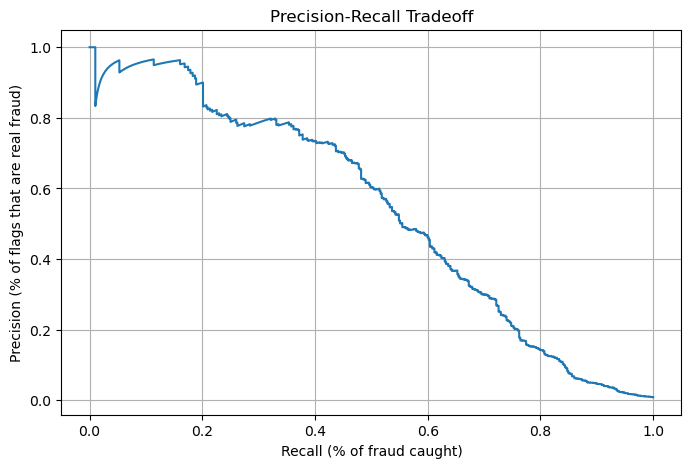

Threshold 90th pct (36.4) | Precision: 0.07 | Recall: 0.86 | Fraud caught: 421/492 | False alarms: 5687
Threshold 95th pct (44.2) | Precision: 0.12 | Recall: 0.82 | Fraud caught: 403/492 | False alarms: 2844
Threshold 97th pct (50.7) | Precision: 0.18 | Recall: 0.76 | Fraud caught: 375/492 | False alarms: 1706
Threshold 99th pct (66.7) | Precision: 0.36 | Recall: 0.65 | Fraud caught: 321/492 | False alarms: 569


In [44]:
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, thresholds_curve = precision_recall_curve(y_test, scores)

plt.figure(figsize=(8, 5))
plt.plot(recall_curve, precision_curve)
plt.xlabel('Recall (% of fraud caught)')
plt.ylabel('Precision (% of flags that are real fraud)')
plt.title('Precision-Recall Tradeoff')
plt.grid(True)
plt.show()

# Try a few thresholds and see the impact
for pct in [90, 95, 97, 99]:
    t = np.percentile(scores_normal, pct)
    preds = (scores > t).astype(int)
    tp = ((preds == 1) & (y_test == 1)).sum()
    fp = ((preds == 1) & (y_test == 0)).sum()
    fn = ((preds == 0) & (y_test == 1)).sum()
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0
    print(f"Threshold {pct}th pct ({t:.1f}) | Precision: {prec:.2f} | Recall: {rec:.2f} | Fraud caught: {tp}/492 | False alarms: {fp}")

In [45]:
best_threshold = np.percentile(scores_normal, 99)
y_pred_final = (scores > best_threshold).astype(int)

print(f"Final threshold: {best_threshold:.2f}")
print()
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Fraud']))
print(f"AUPRC: {average_precision_score(y_test, scores):.4f}")

Final threshold: 66.68

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     56863
       Fraud       0.36      0.65      0.46       492

    accuracy                           0.99     57355
   macro avg       0.68      0.82      0.73     57355
weighted avg       0.99      0.99      0.99     57355

AUPRC: 0.5374
